### Questions:
- Can you use GPT2 tokenizer w/o padding?
- Hoes before bros? - check the avg sentiment with text message sentiments with different
people
- what is a reasonable size for the dataset for fine-tuned model to behave well enough
- overfitting, train with added tokens for for fewer epochs

In [1]:
import pandas as pd
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np
import random
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Trainer, GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup, TrainingArguments, DataCollatorForLanguageModeling
from tqdm import tqdm, trange
import torch.nn.functional as F
import csv
import pickle
import string
import matplotlib.pyplot as plt
import re
from collections import Counter

In [2]:
msg_from_ex = pickle.load(open("/Users/bayesiandater/ex_bot/resources/msg_from_ex", "rb"))
msg_from_ex = [m.lower() for m in msg_from_ex if m.strip() != ""]

In [3]:
len(msg_from_ex)

159

In [4]:
msg_from_ex

['thanks for sending it haha',
 'i love it',
 'lmaoooo',
 'the grad ceremony rip',
 'and happy grad if you are graduating !',
 'hope you are doing well',
 'all water under the bridge',
 'haha it’s chill dude',
 'hvae fun!',
 'sounds good haha',
 'noice noice',
 'noice noice',
 'woah',
 'i have too much to do at the moment',
 'sorry',
 'until my thesis is done',
 'uh i am cooped at my home',
 'fair i guess',
 'oofs',
 'okie will do',
 'e commerce films??',
 'i guess',
 'i mean',
 'classroom',
 'in a',
 'there are cameras',
 'lmaooo',
 'privacy concerns',
 'ohhh',
 'have dinner plans',
 'uhh no eh i can’t',
 'ahh makes sense makes sense',
 'i am an absolute saint',
 'i was positive 1.5 months ago',
 'as in ?',
 'uhh not sure about regularly',
 'i was positive already',
 'issok',
 'ooof',
 'i am at the gate eh',
 'okay okay',
 'i am reaching utown in like 5 mins',
 'heyyo',
 'i will prolly come like 8ish',
 'yesss ?',
 'will skip dinner',
 'i am eating too much tomorrow',
 'yee i think nv

In [4]:
rng = np.random.default_rng(713)
train_idx = rng.integers(low=0, high=len(msg_from_ex), size=int(0.8 * len(msg_from_ex)))
valid_idx = [i for i in range(len(msg_from_ex)) if i not in train_idx]
train_ls, valid_ls = np.array(msg_from_ex)[train_idx], np.array(msg_from_ex)[valid_idx]

#### decide on the number of sentence length to feed into the model

(array([54., 27., 24., 14.,  3.,  3.,  0.,  1.,  0.,  1.]),
 array([ 1. ,  3.1,  5.2,  7.3,  9.4, 11.5, 13.6, 15.7, 17.8, 19.9, 22. ]),
 <BarContainer object of 10 artists>)

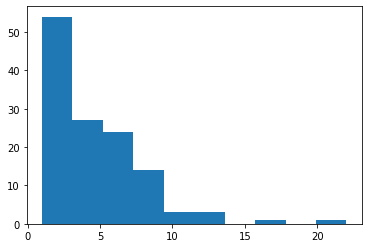

In [5]:
plt.hist([len(m.strip().split()) for m in train_ls])

In [6]:
# get the custom tokens to add to tokenizer
# get the GPT2 token list
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

GPT2_tokens = []
for w in tokenizer.encoder.keys():
    w = w.strip("Ġ").lower()
    GPT2_tokens.append(w)
    
# only add all whole words from both train + valid sets 
# that are not in the original GPT2 tokenizer's vocabulary 15
all_words = []
for m in msg_from_ex:
    m = m.strip(string.punctuation).lower().split()
    all_words += m

added_tokens = []
for word, freq in Counter(all_words).most_common():
    if word not in GPT2_tokens:
        added_tokens.append(word)
        
del tokenizer

In [7]:
class MSG(Dataset):  
    def __init__(self, ls_stc, truncate=False, gpt2_type="gpt2", max_length=1024, added_tokens=None):

        self.tokenizer = GPT2Tokenizer.from_pretrained(gpt2_type)
        special_tokens = {'pad_token':'<|pad|>','sep_token':'<|sep|>'}
        self.tokenizer.add_special_tokens(special_tokens)
        if added_tokens is not None:
            self.tokenizer.add_tokens(added_tokens)
        self.msgs = []
        
        for m in ls_stc:
            m = torch.tensor(
                self.tokenizer.encode(self.tokenizer.bos_token + f"{m[:max_length]}" + self.tokenizer.eos_token, \
                                      max_length=15, padding="max_length", truncation=True))

            self.msgs.append(m)
        
        if truncate:
            self.msgs = self.msgs[:20000]
            
        self.msgs_count = len(self.msgs)
        
    def __len__(self):
        return self.msgs_count

    def __getitem__(self, item):
        return self.msgs[item]
    


In [8]:
ds_custom_train = MSG(train_ls, truncate=True, gpt2_type="gpt2", added_tokens=added_tokens)  
ds_custom_valid = MSG(valid_ls, truncate=True, gpt2_type="gpt2", added_tokens=added_tokens)  

ds_base_train = MSG(train_ls, truncate=True, gpt2_type="gpt2", added_tokens=None)  
ds_base_valid = MSG(valid_ls, truncate=True, gpt2_type="gpt2", added_tokens=None) 

In [9]:
data_collator = DataCollatorForLanguageModeling(
        tokenizer=ds_custom_train.tokenizer,
        mlm=False
    )

In [10]:
training_args = TrainingArguments(
    output_dir="/Users/bayesiandater/ex_bot",          # output directory
    num_train_epochs=6,              # total # of training epochs
    per_device_train_batch_size=10,  # batch size per device during training
    per_device_eval_batch_size=10,   # batch size for evaluation
    warmup_steps=200,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    prediction_loss_only=True,
    save_steps=1000 
)

In [11]:
device= "gpu" if torch.cuda.is_available() else "cpu"

model_custom = GPT2LMHeadModel.from_pretrained('gpt2')
model_custom.resize_token_embeddings(len(ds_custom_train.tokenizer))
model_custom = model_custom.to(device)


In [ ]:
trainer = Trainer(
    model=model_custom,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    data_collator=data_collator,
    train_dataset=ds_custom_train,         # training dataset
    eval_dataset=ds_custom_valid            # evaluation dataset
)

trainer.train()

In [14]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 71
  Batch size = 10


{'eval_loss': 7.913658618927002,
 'eval_runtime': 1.1015,
 'eval_samples_per_second': 64.46,
 'eval_steps_per_second': 7.263,
 'epoch': 6.0}

### 1. greedy search

In [18]:
max_length = 50 

for j, m in enumerate(ds_custom_valid):
    print(j)
    ops = model_custom.generate(m[:3].unsqueeze(0), max_length = max_length)
    
    for i, beam in enumerate(ops):
        print(ds_custom_train.tokenizer.decode(beam, skip_special_tokens=True))


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0
i love this post
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


all water
 yee 

all water
 yee 
 yee
2
haha
 yee
3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


sounds.sound
 yee sound
 yee sound
 yee sound
 yee sound
 yee sound

sound
4
noice noice  i-cricket.com
 yee
5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


sorry 4/5 

The following is a prolly 
 yee 
 yee 
 yee 
 yee 
 yee 
 yee 
 yee 
 yee 
 yee 
 yee 
 yee 
 yee 
 yee 
 yee 
 yee 
 yee 
 yee 
 yee 
 yee 

6


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


fair i.imgur. bopez.png
 yee.png
 yee.png
 yee.png
 yee. yee 

i.imgur. i.imgur yee.png
 yee.png
 yee. yee 
 yee.png

7
oofs 4/5 

The New York Times
 yee
8


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


okie williams.com
9
ahh makeshift_tutorials
10
i am
 yee 
 yee
11


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


as in
 yee
12


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


uhh notify me
 yee notify me
 yee not yee notify me
 yee not yee notify me

I'm not a stranger
13
i was a guest yee
14


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


issok 4/5 

The New York Times
 yee
15
ooof 4/5 

The New York Times
 yee
16
okay
17


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


i am
 yee 
 yee
18
heyyo 4/5 

The New York Times
 yee
19


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


i will be able to read
 yee
20
yee i
 yee  j
 yee 
 yee
21
so free
22


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

yup 4/5 

The New York Times
 yee
23
taking it 4/5
24
coz you 4/5
25
ooh williams.com
26


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

i didn’t  james-michael-s-and- 4/5  james-m yee  james-m
27
its just 4/5 
 yee
28
sat afternoon
 yee
29
no biggie 
 4/5
30


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


oh okay
31
i am
 yee 
 yee
32
yes?
 yee
33


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


oof ios_ 4/5
34
yup i.imgur. yee.imgur.
35
alrighty honey
36


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


which makes jupyter 4/5 
 yee
37


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


and also 4/5 4/5 prolly 4/5 4/5  -1
 yee  -1
 yee  -1
 yee  -1
 yee  -1
 yee  -1
 yee  -1
 yee  -1
 yee  -1
 yee  -1
 yee  -1
38
i think it's cool to be a dick
 yee
39


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

nvm then
 yee
40
oooof ok
41
oh okay
42
nope
 yee
43
so i 4/5
44


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


uh no
 yee
45
coz 4/5 

The Best of prolly 
 yee
46


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

and have 4/5 jupyter prolly 4/5 4/5 
 yee 

"
 yee 
 yee 
 yee 
 yee 
 yee 
 yee 
 yee 
 yee 
 yee 
 yee 
 yee 
 yee 
 yee 
 yee 
 yee 
 yee 
 yee 
 yee 

47
okay
48
okie sure
49
yes of course
 yee
50


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

ooof 4/5 

The New York Times
 yee
51
yes of course
 yee
52
hope_to_ 4/5
53
there you are
54


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


bread is a prolly 
 yee
55
i want to know more
56


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


yes 4/5 

The New York Times
 yee
57


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

noice i-am-online-online-online-online-online-online-online-online-online-online-online-online-online-online-online-online-online-online-online-online-online-online-
58
for sure
 yee
59
doing too much
 yee
60
it be
 yee
61


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


lmaooo 4/5 

The New York Times
 yee
62


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


just coz.
 yee.

I prolly.
 yee.
 yee.
 yee.
 yee.
 yee yee.
 yee oooof.
 yee yee yee.
 yee yee.
 yee yee yee.
 yee yee ooh
63
yesss gotchaa  i-cricket.com
 yee
64
ooof issa
65
uh go
66


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

adds
 yee
67
woah reallygoodguy
 yee 
 yee
68
at random
 yee
69


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


coz i.imgur. 4/5.imgur.
70
uh ya 4/5


In [18]:
max_length = 50 

for m in ds_custom_valid:
    ops = model_custom.generate(m[:3].unsqueeze(0), max_length = max_length)
    for i, beam in enumerate(ops):
        print(i, ds_custom_train.tokenizer.decode(beam, skip_special_tokens=True))
    break
    
    

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

i love this post
all water
 ooh 
all water
 ooh 
 ooh
haha


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


sounds.sound
 ooh
noice noice 
 aaaak 

The first yup 
 ooh


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


sorry aaaak 

The following is a yup 
 ooh 
 ooh 
 ooh 
 ooh 
 ooh
fair i aaaak


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


oofs aaaak 

The following is a yup 
 ooh 
 ooh 
 ooh 
 ooh 
 ooh 
 ooh 
 ooh


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


okie williams.com
 ooh williams.com
 ooh williams.com
 ooh will ooh williams ooh
ahh makes
 ooh 

This is a very yup 
 ooh


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


i am_pizza_dummy
 ooh
as in
 ooh


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


uhh notify me yup 
 ooh 

I yup 
 ooh 
 oofs 

I
i was a guest yup


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


issok aaaak 

The following is a yup 
 ooh 
 ooh 
 ooh 
 ooh 
 ooh 
 ooh 
 ooh


KeyboardInterrupt: 

### 2. beam search

In [19]:
# beam search
max_length = 50 
num_beams=20
num_return_sequences= 20
early_stopping=True 

total = []

for j, m in enumerate(ds_custom_valid):
    ops = model_custom.generate(m[:3].unsqueeze(0), 
                                max_length = max_length,
                               num_beams=num_beams,
                                num_return_sequences=num_return_sequences,
                                early_stopping=early_stopping)
    
    for i, beam in enumerate(ops):
        o = ds_custom_train.tokenizer.decode(beam, skip_special_tokens=True)
        o = re.sub(r"[ +|\n]", " ", o).strip("\n ")
        o = re.sub(r" +", " ", o).strip("\n ")
        if o not in ["",  " "]:
            print(o)
            total.append(o)
            
    if j == 1:
        break

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


i love it yee
i love it
i love this song yee
i love this post yee
i love this photo yee
i love this topic yee
i love this thread yee
i love this post
i love this review yee
i love yee
i love this comment yee
i love this site yee
i love this comment
i love this blog yee
i love
i love this topic
i lovevideo.com
i love this item yee
i love it when you
i love this blog
all water yee
all water 4/5 yee
all water yee water yee
all water yee yee
all water jupyter yee
all water
all watercolor yee
all water yee Advertisements
all water 4/5 yee
all water yee water
all water yee yee
all water 7/8 yee
all water yee
all water jupyter yee
all water yee all water
all water yee
all water yee back yee
all water 4/5
all watercolor
all water, jupyter


In [21]:
# beam search
max_length = 50 
num_beams=20
num_return_sequences= 10
early_stopping=True 

total = []

for j, m in enumerate(ds_custom_valid):
    ops = model_custom.generate(m[:3].unsqueeze(0), 
                                max_length = max_length,
                               num_beams=num_beams,
                                num_return_sequences=num_return_sequences,
                                early_stopping=early_stopping)
    
    for i, beam in enumerate(ops):
        o = ds_custom_train.tokenizer.decode(beam, skip_special_tokens=True)
        o = re.sub(r"[ +|\n]", " ", o).strip("\n ")
        o = re.sub(r" +", " ", o).strip("\n ")
        if o not in ["",  " "]:
            print(o)
            total.append(o)
            
    if j == 1:
        break

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


i love it yee
i love it
i love this song yee
i love this post yee
i love this photo yee
i love this topic yee
i love this thread yee
i love this post
i love this review yee
i love yee
all water yee
all water 4/5 yee
all water yee water yee
all water yee yee
all water jupyter yee
all water
all watercolor yee
all water yee Advertisements
all water 4/5 yee
all water yee water


In [ ]:
# beam search
max_length = 50 
num_beams=20
num_return_sequences= 20
early_stopping=True 

total = []

for j, m in enumerate(ds_custom_valid):
    ops = model_custom.generate(m[:3].unsqueeze(0), 
                                max_length = max_length,
                               num_beams=num_beams,
                                num_return_sequences=num_return_sequences,
                                early_stopping=early_stopping)
    
    for i, beam in enumerate(ops):
        o = ds_custom_train.tokenizer.decode(beam, skip_special_tokens=True)
        o = re.sub(r"[ +|\n]", " ", o).strip("\n ")
        o = re.sub(r" +", " ", o).strip("\n ")
        if o not in ["",  " "]:
            print(o)
            total.append(o)
            
    if j == 1:
        break

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


i love it ooh
i love it
i love this topic ooh
i love this thread ooh
i love this post ooh
i love this song ooh
i love
i love this post
i love ooh
i love this ooh
i love this item ooh
i love this topic
i love this story ooh
i love this blog ooh
i love this comment
i love this place ooh
i love this thread
i love it when you
i love this song
i love this story
all water ooh
all water ooh water ooh
all water yup ooh
all water ooh ooh
all water hungover ooh
all water ooh ooh
all water
all water aaaak ooh
all water thingy ooh
all water lmaoo ooh
all water ooh water
all water ooh all water
all water yup ooh
all water ooh
all water yup
all water ooh All water
all water yup
all water hungover
all water aaaak
all water thingy


In [ ]:
max_length = 50 
num_beams=20
num_return_sequences= 20
early_stopping=True 
no_repeat_ngram_size=2
total = []

for j, m in enumerate(ds_custom_valid):
    ops = model_custom.generate(m[:3].unsqueeze(0), 
                                max_length = max_length,
                               num_beams=num_beams,
                                num_return_sequences=num_return_sequences,
                                no_repeat_ngram_size=no_repeat_ngram_size,
                                early_stopping=early_stopping)
    
    for i, beam in enumerate(ops):
        o = ds_custom_train.tokenizer.decode(beam, skip_special_tokens=True)
        o = re.sub(r"[ +|\n]", " ", o).strip("\n ")
        o = re.sub(r" +", " ", o).strip("\n ")
        if o not in ["",  " "]:
            print(o)
            total.append(o)
            
    if j == 1:
        break

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


i love it ooh
i love it
i love this topic ooh
i love this thread ooh
i love this post ooh
i love this song ooh
i love
i love this post
i love ooh
i love this ooh
i love this item ooh
i love this topic
i love this story ooh
i love this blog ooh
i love this comment
i love this place ooh
i love this thread
i love it when you
i love this song
i love this story
all water ooh
all water yup ooh
all water ooh ooh
all water hungover ooh
all water
all water aaaak ooh
all water thingy ooh
all water lmaoo ooh
all water ooh water
all water yup ooh
all water ooh
all water yup
all water hungover ooh
all water yup
all water aaaak ooh
all water thingy ooh
all water lmaoo ooh
all water hungover
all water aaaak
all water thingy


### 3. sampling

In [70]:
max_length = 100
num_beams=20
num_return_sequences= 20
early_stopping=True 
no_repeat_ngram_size=2
do_sample = True
total = []

for j, m in enumerate(ds_custom_valid):
    ops = model_custom.generate(m[:3].unsqueeze(0), 
                                max_length = max_length,
                                do_sample=do_sample,
                                num_return_sequences=num_return_sequences,
                                no_repeat_ngram_size=no_repeat_ngram_size,
                                early_stopping=early_stopping)
    
    for i, beam in enumerate(ops):
        o = ds_custom_train.tokenizer.decode(beam, skip_special_tokens=True)
        o = re.sub(r"[ +|\n]", " ", o).strip("\n ")
        o = re.sub(r" +", " ", o).strip("\n ")
        if o not in ["",  " "]:
            print(o)
            total.append(o)
            
    if j == 1:
        break

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


i love this piece?
i lovevideo
i love my life so much
i love and dont get married this site
i love redbox okie
i love this book, it's essential reading for anyone needing a ahh
i love this thread
i love tryna new
i love it
i love it
i love sweethearts
i love this post
i love pink
i love life
i love it
i love this song okie
i love when i find my skin dry but i am allergic to this i dont smoke it
i love these beads... yee
i love this article
i love_yourbasket okie _dishwasher _faux_pork_crying_door gotcha _flat_nose 👀 is_dog_tongue
all watercolor ink and sparkling ink, you will need to get the item you want.
all water : water hot water lhb okie hot cold water hungover hot yee cold cold 4/5 hot salt water mh
all water okie the_water
all watercolor
all watercolors jupyter okie heyyo
all water.water.your. can’t. your. okie that
all water-color
all water in your drink okie
all water water color
all water okie
all water (8 x 10) okie all
all water
all watercolor
all watercolor all
all water o

In [68]:
max_length = 100
num_beams=20
num_return_sequences= 20
early_stopping=True 
no_repeat_ngram_size=2
do_sample = True
total = []

for j, m in enumerate(ds_custom_valid):
    ops = model_custom.generate(m[:3].unsqueeze(0), 
                                max_length = max_length,
                                do_sample=do_sample,
                                num_return_sequences=num_return_sequences,
                                no_repeat_ngram_size=no_repeat_ngram_size,
                                early_stopping=False)
    
    for i, beam in enumerate(ops):
        o = ds_custom_train.tokenizer.decode(beam, skip_special_tokens=True)
        o = re.sub(r"[ +|\n]", " ", o).strip("\n ")
        o = re.sub(r" +", " ", o).strip("\n ")
        if o not in ["",  " "]:
            print(o)
            total.append(o)
            
    if j == 1:
        break

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


i love this post
i love the way i wish it was possible" okie
i love this site okie
i love watching adobe sexy okie
i love this i dont gotcha i will never forget okie
i love this shit
i love >>
i lovevideo.video okie
i love watching this video
i love
i love this post(s)
i love it okie
i love white bread butiyyur, my_cupcake i love hotcakes, hotbread
i love that how come its not a baby. okie it
i love it
i love watching ralphs
i love https://www
i love to see
i love this product
i love this topic
all water_color.png gotchaa orew.jpg
all water, l yay , b c •
all water okie all fire gotchaa
all water milk yee wine okie
all water
all water no splash v4 all waterno splash
all water okie no ice 0 gotcha
all water okie t 4/5 it’s all my
all water, wind,
all watercolour the last word okie
all water1 the water2 theWater theWisemore. ooof THEWISMOROTHTHEWOROOM yee thewispolicyos.
all water
all watercolor
all watermark 4/5
all water is not coz the one who gotchaa
all waterisland bopez yee
all wate

In [16]:
max_length = 100
num_beams=10
num_return_sequences= 10
early_stopping=True 
no_repeat_ngram_size=2
do_sample = True
temperature=0.9
top_k = 20
total = []

for j, m in enumerate(ds_custom_valid):
    ops = model_custom.generate(m[:5].unsqueeze(0), 
                                max_length = max_length,
                                do_sample=do_sample,
                                num_return_sequences=num_return_sequences,
                                no_repeat_ngram_size=no_repeat_ngram_size,
                                top_k = top_k,
                                temperature=temperature,
                                early_stopping=early_stopping)
    
    for i, beam in enumerate(ops):
        o = ds_custom_train.tokenizer.decode(beam, skip_special_tokens=True)
        o = re.sub(r"[ +|\n]", " ", o).strip("\n ")
        o = re.sub(r" +", " ", o).strip("\n ")
        if o not in ["",  " "]:
            print(o)
            total.append(o)
            
    if j == 1:
        break

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


i love it issok 1.5 uhh
i love it
i love it 1.5
i love it heyyo 1.5 yee lmaooo uhh dinner/drinks
i love it uhh dinner/drinks a 1.5 lmaooo yee
i love it lmaooo uhh yee prolly
i love it heyyo 1.5 Share lmao lmaooo
i love it coz
i love it coz
i love it issok
all water under the sun yee
all water under the sun 1 cup don’t
all water under the moon uhh
all water under the sun, rain, sunshine, storms 1.5
all water under the broiler 1.5
all water under the sun at noon or weirdly
all water under the sun water is a shade under. yee
all water under the sun yee
all water under the sun lmaooo uhh
all water under the hood


In [ ]:
max_length = 100
num_beams=10
num_return_sequences= 10
early_stopping=False
no_repeat_ngram_size=2
do_sample = True
temperature=1
top_k = 50
total = []

for j, m in enumerate(ds_custom_valid):
    ops = model_custom.generate(m[:5].unsqueeze(0), 
                                max_length = max_length,
                                do_sample=do_sample,
                                num_return_sequences=num_return_sequences,
                                no_repeat_ngram_size=no_repeat_ngram_size,
                                top_k = top_k,
                                temperature=temperature,
                                early_stopping=early_stopping)
    
    for i, beam in enumerate(ops):
        o = ds_custom_train.tokenizer.decode(beam, skip_special_tokens=True)
        o = re.sub(r"[ +|\n]", " ", o).strip("\n ")
        o = re.sub(r" +", " ", o).strip("\n ")
        if o not in ["",  " "]:
            print(o)
            total.append(o)
            
    if j == 1:
        break

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


i love it tryna
i love it idk lily liana ro yup
i love it cnn"
i love it uhh the way things are and lmaooo the heyyo
i love it issok vid dev en espa lmaooo
i love it jupyter
i love it issok pimping
i love it coz
i love it issok 1.5
i love it lmaooo 1.5 uhh
all water under the sun
all water under the table for indoor plumbing yee
all water under the bed
all water under the table \ heyyo
all water under the sun yee uhh okie
all water under the moon
all water under the sun and dust rain snow dinner/drinks okie
all water under the sun the water that is heyyo
all water under the covers yay
all water under the sun


In [ ]:
max_length = 100
num_beams=10
num_return_sequences= 10
early_stopping=False
no_repeat_ngram_size=2
do_sample = True
temperature=0.9
top_k = 10
total = []

for j, m in enumerate(ds_custom_valid):
    ops = model_custom.generate(m[:5].unsqueeze(0), 
                                max_length = max_length,
                                do_sample=do_sample,
                                num_return_sequences=num_return_sequences,
                                no_repeat_ngram_size=no_repeat_ngram_size,
                                top_k = top_k,
                                temperature=temperature,
                                early_stopping=early_stopping)
    
    for i, beam in enumerate(ops):
        o = ds_custom_train.tokenizer.decode(beam, skip_special_tokens=True)
        o = re.sub(r"[ +|\n]", " ", o).strip("\n ")
        o = re.sub(r" +", " ", o).strip("\n ")
        if o not in ["",  " "]:
            print(o)
            total.append(o)
            
    if j == 1:
        break

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


i love it jupyter lmaooo
i love it coz prolly 1.5 yee The Last of Us yup
i love it slacked
i love it lmaooo
i love it noice
i love it issok
i love it issok
i love it
i love it heyyo 1.5
i love it heyyo
all water under the hood.
all water under the sun, rain or shine 1.5
all water under the sun lmaooo hot air dinner/drinks hot sauce 1.5
all water under the sun yee all rain no rain dont forget
all water under the table
all water under the sun 1.5
all water under the sun dinner/drinks
all water under the sun yee
all water under the table
all water under the sun, uhh


In [ ]:
# open-ended generation
class MSG2(Dataset):  
    def __init__(self, ls_stc, truncate=False, gpt2_type="gpt2", max_length=1024, added_tokens=None):

        self.tokenizer = GPT2Tokenizer.from_pretrained(gpt2_type)
        special_tokens = {'pad_token':self.tokenizer.eos_token ,'sep_token':'<|sep|>'}
        self.tokenizer.add_special_tokens(special_tokens)
        if added_tokens is not None:
            self.tokenizer.add_tokens(added_tokens)
        self.msgs = []
        max_len = 0
        
        for m in ls_stc:
            m = torch.tensor(
                self.tokenizer.encode(self.tokenizer.bos_token + f"{m[:max_length]}" + self.tokenizer.eos_token, \
                                      max_length=15, padding="max_length", truncation=True))
            max_len = max(len(m), max_len)

            self.msgs.append(m)
        
        if truncate:
            self.msgs = self.msgs[:20000]
            
        self.msgs_count = len(self.msgs)
        
    def __len__(self):
        return self.msgs_count

    def __getitem__(self, item):
        return self.msgs[item]

ds_custom_valid2 = MSG2(valid_ls, truncate=True, gpt2_type="gpt2", added_tokens=added_tokens)  

max_length = 100
num_beams=10
num_return_sequences= 10
early_stopping=False
no_repeat_ngram_size=2
do_sample = True
temperature=0.9
top_k = 10

for j, m in enumerate(ds_custom_valid2):
    ops = model_custom.generate(m[:5].unsqueeze(0), 
                                max_length = max_length,
                                do_sample=do_sample,
                                num_return_sequences=num_return_sequences,
                                no_repeat_ngram_size=no_repeat_ngram_size,
                                top_k = top_k,
                                temperature=temperature,
                                early_stopping=early_stopping)
    
    for i, beam in enumerate(ops):
        o = ds_custom_train.tokenizer.decode(beam, skip_special_tokens=True)
        o = re.sub(r"[ +|\n]", " ", o).strip("\n ")
        o = re.sub(r" +", " ", o).strip("\n ")
        if o not in ["",  " "]:
            print(o)
            total.append(o)
            
    if j == 1:
        break
        

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


i love it bopez _museum_lose_your_ idk _my_life_ yee _numbers_of_the_century _new_facts if ( _check_empty()) okie _is_not_a_true gotchaa _no_truth it’s _universe gotcha _ bopez stories timings _
i love it lmaoo
i love it lmaoo
i love it gotchaa tryna okie • gotcha okie gotcha
i love it can’t
i love it bopez
i love it 7/8
i love it lmaoo
i love it bopez
i love it lmao okie
all water under the sun okie
all water under the table
all water under the moon okie
all water under the bed_lose_ gotchaa
all water under the sun
all water under the sun tryna I hungover i okie
all water under the sun okie
all water under the table.
all water under the sun
all water under the table


In [22]:
import gc
gc.collect()

54